<h1 align="center"> TP5 : Simulation of ductile fracture models </h1>
<h2 align="center"> Jérémy Bleyer, Jérémy Hure </h2>

> **Objectives**:
> * Discuss the numerical implementation of various versions of the Gurson-Tvergaard-Needleman (GTN) model
> * Study the influence of coalescence and nucleation models on tensile tests
> * Observe mesh dependency of localized solutions
> * Calibrate a GTN model agains experimental data

We consider here the tensile test of rounded-notch axisymmetric specimen with small diameter $\Phi_0=10$ mm and large diameter $\Phi = 18$ mm. Simulations will be performed in 2D axisymmetric conditions on the upper half of the specimen. The geometry is created and meshed with quadrangles in the `geometry.py`. The mesh size is controlled by a `coarse_size` away from the notch region and a `fine_size` near the notch.

> Note that such computations can be time consuming so that we will voluntarily work with quite large mesh sizes due to time constraints.

## Material behaviour implementation

Implementation of the various material behaviours will be done using `MFront`, an open-source code generator dedicated to material constitutive modeling. The implementation relies on preimplemented behaviours which are detailed here: [Extension of the StandardElastoViscoPlasticity brick to porous materials](https://tfel.sourceforge.net/StandardElastoViscoPlasticityBrick-PorousPlasticity.html), see here [Description of the StandardElastoViscoPlasticity brick](https://tfel.sourceforge.net/StandardElastoViscoPlasticityBrick.html) for its general description.

`MFront` will then compile shared libraries which can be used from the FEniCSx side using the `dolfinx_materials` package. The latter relies on instantiating a so-called `QuadratureMap` which encodes a black-box mapping (via MFront libraries in this case) from *gradients* towards *fluxes*, in this case from strains to stresses. In addition, it also handles internal and external state variables initialization and updates. All quantities are defined at the *quadrature point level*.

In a small strain setting, a non-linear constitutive law can be expressed as a black-box function $\boldsymbol{\sigma}(\boldsymbol{\varepsilon}, \boldsymbol{\alpha})$ where $\boldsymbol{\alpha}$ represent history-dependent state variables. The `QuadratureMap` when associated with a specific behaviour implementation must declare the UFL expression corresponding to the input gradient, here the strain $\boldsymbol{\varepsilon}=\dfrac{1}{2}(\nabla\boldsymbol{u}+\nabla\boldsymbol{u}^\text{T})$, for instance called `"Strain"`. It will then give us access to the corresponding flux $\boldsymbol{\sigma}$ via its declared name, e.g. `"Stress"`.

Finally, standard non-linear residual forms can then be defined using such objects and automatic differentiation can be used to compute the Jacobian form, since MFront also provide consistent tangent operators. A standard Newton solver can then be called to solve the non-linear problem, the constitutive update function being called at each iteration of the Newton method.

> **Disclaimer**: The `dolfinx_materials` package is a very young library so that a few bugs might still be present. Don't hesitate to report it if you find something fishy!

## Work plan

In the [GTN_computation.ipynb](GTN_computation.ipynb) you will find a working implementation for computing a tensile test on an axisymmetric notched specimen.

### Model comparisons
1. From the `GTN.mfront` file, create a  `GTN_NoNucleation.mfront` behaviour which ignores the pore nucleation process. From the latter further degrade it to model the original Gurson model (let us call it `Gurson.mfront`). Compile all behaviours by opening a terminal in the folder and running the command line:

```mfront --obuild --interface=generic GTN.mfront GTN_NoNucleation.mfront Gurson.mfront```

2. For a fine mesh size of `fine_size=0.4``, run the simulations for the three behaviours. Results are stored in a .csv file containing the following data in each column:
* $E_{zz}$ : imposed axial nominal strain (`strain`)
* $f_\text{max}$: maximum value of porosity (for unbroken points) (`fmax`)
* $p$: value of equivalent plastic strain at the specimen center (`p`)
* $\Sigma_{zz}$ : nominal axial stress $\Sigma_{zz}=F/S_0$ (`stress`)
* $\Delta \Phi$: reduction of diameter (`DeltaPhi`)
* Number of broken quadrature points (where $f>0.98f_r$) (`num_broken`)

The already implemented function `load_data(model, mesh_size, R)` returns a dictionary containing these results as a function of the model name `model`, the fine mesh size `mesh_size` and the notch radius `R`.


In [28]:
import numpy as np
import matplotlib.pyplot as plt

def load_data(model, mesh_size, R):
    results = np.loadtxt(f"{model}_mesh_{mesh_size}/results_R{float(R)}.csv", skiprows=1, delimiter=",")
    return {"strain": results[:, 0],
            "fmax": results[:, 1],
            "p": results[:, 2],
            "stress": results[:, 3],
            "DeltaPhi": results[:, 4],
            "num_broken": results[:, 5]}


3. Run the analysis for three notch radius $R=4,6$ and $10$ mm using the GTN model. Discuss the influence of the notch radius on the results. Analyse the evolution of the porosity field for $R=10$.

4. In this notebook, analyze the results in terms of stress/strain curve and porosity evolution. Discuss the influence of the triaxiality ratio on the results.

### Mesh dependency

Run the simulation for $R=4$ mm for the GTN model using mesh sizes `fine_size=0.2` and `fine_size=0.1` and plot the results in the notebook.

### Going further: add viscoplasticity

Define a new GTN behaviour accounting for viscoplasticity instead of rate-dependent plasticity using a Norton behaviour:
$$\dot{\varepsilon}^p = A\left\langle \dfrac{\phi}{K}\right\rangle^n$$
with $A=1\text{ s}^{-1}$, $K=50$ MPa. See [here, sec. 6.2](https://tfel.sourceforge.net/StandardElastoViscoPlasticityBrick-PorousPlasticity.html) for the implementation. 
We want to reach a strain rate of $\varepsilon = 5.10^{-4}\,\text{s}^{-1}$. During the load stepping loop, change accordingly the time step argument of the material object `material.dt` to reach the desired strain rate (by default this `dt=0` for rate-independent behaviours).

Run the model for $R=4$ mm and discuss the evolution of the crack propagation.

## Calibration of X100 steel

We now try to reproduce notched tensile tests on the X100 steel. You will first need to calibrate the hardening model. Then you will need to play with some of the GTN model parameters to reproduce notched tensile tests data.

Available experimental data:
* smooth tension test: $\varepsilon_{eq}^p, \sigma_{eq}$ curve `X100_smooth_tension.csv`
* notched tensile tests: $\Delta \Phi, \Sigma_{zz}$ data points `X100_notched_tension.csv`


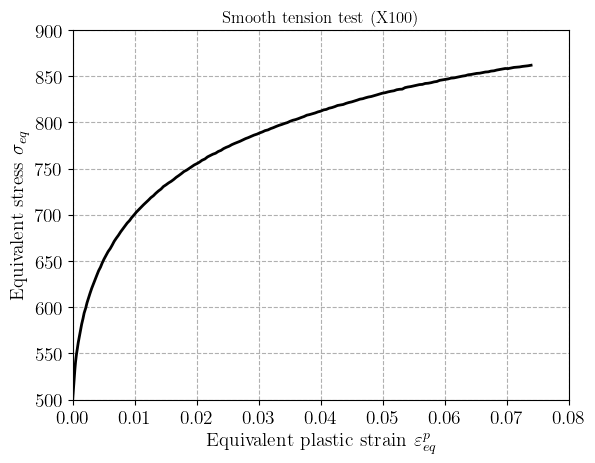

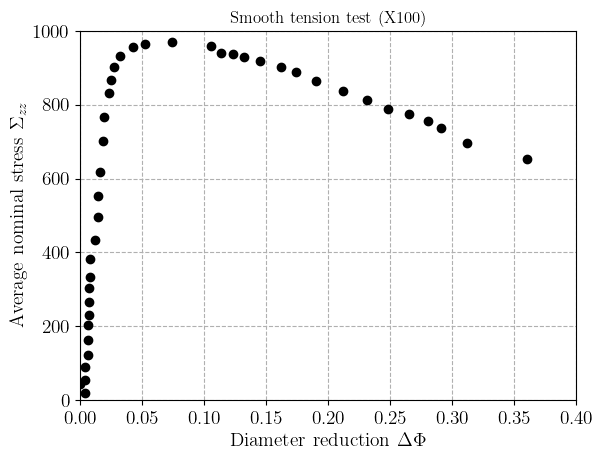

In [23]:
X100_ST = np.loadtxt("X100_smooth_tension.csv", delimiter=",", skiprows=1)
X100_NT = np.loadtxt("X100_notched_tension.csv", delimiter=",", skiprows=1)

plt.plot(X100_ST[:, 0], X100_ST[:, 1], '-k')
plt.xlabel(r"Equivalent plastic strain $\varepsilon^p_{eq}$")
plt.ylabel(r"Equivalent stress $\sigma_{eq}$")
plt.title("Smooth tension test (X100)")
plt.show()


plt.plot(X100_NT[:, 0], X100_NT[:, 1], 'ok')
plt.xlabel(r"Diameter reduction $\Delta \Phi$")
plt.ylabel(r"Average nominal stress $\Sigma_{zz}$")
plt.title("Smooth tension test (X100)")
plt.show()

For the hardening calibration function, you can use the `scipy.optimize.curve_fit` function as follows:
> Example on how to use `curve_fit` to fit a function `func` on a data set `xdata, ydata`:
> ```python
> def func(x, a, b, c):
>     return a * np.exp(-b * x) + c
> 
> popt, pcov = curve_fit(func, xdata, ydata)
> 
> print(popt)
> >>> array([2.56274217, 1.37268521, 0.47427475])
> 
> plt.plot(xdata, func(xdata, *popt), 'r-',
> ```